In [178]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('transformed_371.csv')
data.head(13)

,year,month,revenue,quantity,unit_price,discount,item_number,customer_id,document_id,index,...,discount_entropy,customer_id_entropy,item_number_entropy,document_id_entropy,high_priced,high_quantity,recurrent_purchase,one_time_purchase,chance_recurrent,high_lift
0,2013,1,440655.725,39069.0,31.020550,0.0,253,1291,1639,1,...,-0.0,9.997103,6.010735,10.476548,161,359,3,523,0.267027,1306
1,2013,2,376620.885,33120.0,32.618998,0.0,247,1173,1435,2,...,-0.0,9.794298,6.237180,10.246280,116,375,3,346,0.357792,953
2,2013,3,395506.530,41112.0,29.558159,0.0,278,1173,1443,3,...,-0.0,9.869265,6.196558,10.243339,160,374,1,635,0.334408,1127
3,2013,4,443267.052,35320.0,30.286281,0.0,278,1204,1592,4,...,-0.0,9.912832,5.895749,10.408360,189,355,2,814,0.308857,1532
4,2013,5,502755.490,42051.0,31.821201,0.0,366,1332,1680,5,...,-0.0,10.030326,6.161299,10.476226,217,393,4,733,0.285477,1513
5,2013,6,442943.898,33701.0,28.025233,0.0,400,1323,1654,6,...,-0.0,10.083261,6.066514,10.485456,196,425,1,974,0.248784,1582
6,2013,7,502307.400,44532.0,28.271810,0.0,386,1429,1742,7,...,-0.0,10.219242,5.905503,10.555054,205,399,10,1125,0.236368,1859
7,2013,8,470486.542,35768.0,27.189661,0.0,394,1402,1719,8,...,-0.0,10.142890,5.830765,10.530652,168,353,7,998,0.240131,1966
8,2013,9,447937.780,50500.0,27.823651,0.0,375,1252,1529,9,...,-0.0,9.918292,5.971976,10.332273,179,330,3,963,0.218847,1549
9,2013,10,471640.682,49151.0,25.648075,0.0,377,1466,1814,10,...,-0.0,10.240131,5.868819,10.616488,185,423,2,995,0.260662,1821


In [203]:
data.columns

Index(['year', 'month', 'revenue', 'quantity', 'unit_price', 'discount',
       'item_number', 'customer_id', 'document_id', 'index', 'revenue_skew',
       'quantity_skew', 'unit_price_skew', 'discount_skew', 'revenue_entropy',
       'quantity_entropy', 'unit_price_entropy', 'discount_entropy',
       'customer_id_entropy', 'item_number_entropy', 'document_id_entropy',
       'high_priced', 'high_quantity', 'recurrent_purchase',
       'one_time_purchase', 'chance_recurrent', 'high_lift'],
      dtype='object')

test model performances without the target variable in the X. try to see if the mpodel perform better than just a simple correlation of the past to the future months.

In [179]:
# Function for X, y
def encoder(df, target, window=1, cut=1, drop_timeline=True):
    import pandas as pd
    import numpy as np

    # Ensure the DataFrame has a proper index
    df = df.reset_index(drop=True)
    
    # New column 'target' that is the reverse rolling mean of the target column
    df['target'] = df[target].rolling(window=window).mean().shift(-1)
    
    # Drop the last unit_distance rows
    df = df.dropna()
    
    # Drop last row(s)
    df = df.drop(df.tail(cut).index)
    
    if drop_timeline:
        df = df.drop('year', axis=1)
    
    # Return X and y
    X = df.drop(['target', 'index'], axis=1)
    y = df['target']
    
    # Rolling average
    X['revenue_recent'] = df['revenue'].rolling(window=3).mean()
    X['quantity_recent'] = df['quantity'].rolling(window=3).mean()
    X['document_id_recent'] = df['document_id'].rolling(window=3).mean()
    
    # Scale the data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Fill na with -1
    X = X.fillna(-1)
    
    return X, y

In [180]:
X, y = encoder(data, 'revenue', window=1, cut=1, drop_timeline=True)
print(X['revenue'].head(), y.head())

0   -1.829467
1   -1.975086
2   -1.932139
3   -1.823529
4   -1.688248
Name: revenue, dtype: float64 0    376620.885
1    395506.530
2    443267.052
3    502755.490
4    442943.898
Name: target, dtype: float64


In [181]:
# XGBoost
def xgboost(data, target='revenue', window=1, cut=1, drop_timeline=True, estimators=40, lr=0.1, g=0.5):
    from xgboost import XGBRegressor
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score, mean_squared_error
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    import pandas as pd

    # Define MAPE function
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true))
    
    # Define Mean Percent Correct
    def mean_percent_correct(y_true, y_pred):
        threshold = np.std(y_true) / 2
        correct = np.abs(y_true - y_pred) < threshold
        return np.mean(correct)

    # Split data
    X, y = encoder(data, target, window=window, cut=cut, drop_timeline=drop_timeline)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Initialize KFold
    kf = KFold(n_splits=2, shuffle=True, random_state=42)

    # Lists to store performance metrics
    mse_scores = []
    r2_scores = []
    mape_scores = []
    predictions = []
    mpc_scores = []

    # K-Fold Cross-Validation
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Model
        model = XGBRegressor(n_estimators=estimators, learning_rate=lr, gamma=g)
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Calculate performance metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mpc = mean_percent_correct(y_test, y_pred)
        
        # Append metrics to lists
        mse_scores.append(mse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        predictions.append(y_pred)
        mpc_scores.append(mpc)

    # Calculate average performance metrics
    avg_r2 = np.mean(r2_scores)
    avg_mse = np.mean(mse_scores)
    avg_mape = np.mean(mape_scores)
    avg_mpc = np.mean(mpc_scores)

    print(f"Average R2 Score: {avg_r2}")
    print(f"Average Mean Squared Error: {avg_mse}")
    print(f"Average MAPE: {avg_mape}")
    print(f"Average Mean Percent Correct: {avg_mpc}")

    # Feature importance
    import matplotlib.pyplot as plt
    from xgboost import plot_importance

    # Fit model on the entire dataset for feature importance
    model.fit(X_scaled, y)

    # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))

    # Plot feature importance on the first subplot
    plot_importance(model, ax=ax[0], importance_type='weight')
    ax[0].set_title('Feature Importance')

    # Plot predictions on the second subplot
    ax[1].plot(y_test.values, label='Observed', color='blue', linewidth=2, marker='o')
    ax[1].plot(y_pred, label='Predicted', color='red', linewidth=2, marker='x', linestyle='dashed')
    ax[1].set_title('XGBoost Predictions')
    ax[1].set_ylabel(f'{target} Value')
    ax[1].set_xlabel('Sample Index')
    ax[1].legend()

    # Calculate absolute error
    errors = np.abs(y_test.values - y_pred)

    # Plot errors as bars on the same subplot
    ax[1].bar(range(len(errors)), errors, alpha=0.2, color='red', label='Absolute Error')

    # Add legend for the error bars
    ax[1].legend()

    # Display the combined figure
    plt.tight_layout()
    plt.show()

Average R2 Score: 0.5062960194092319
Average Mean Squared Error: 91077.14196526725
Average MAPE: 0.09453852307461916
Average Mean Percent Correct: 0.6598793363499246


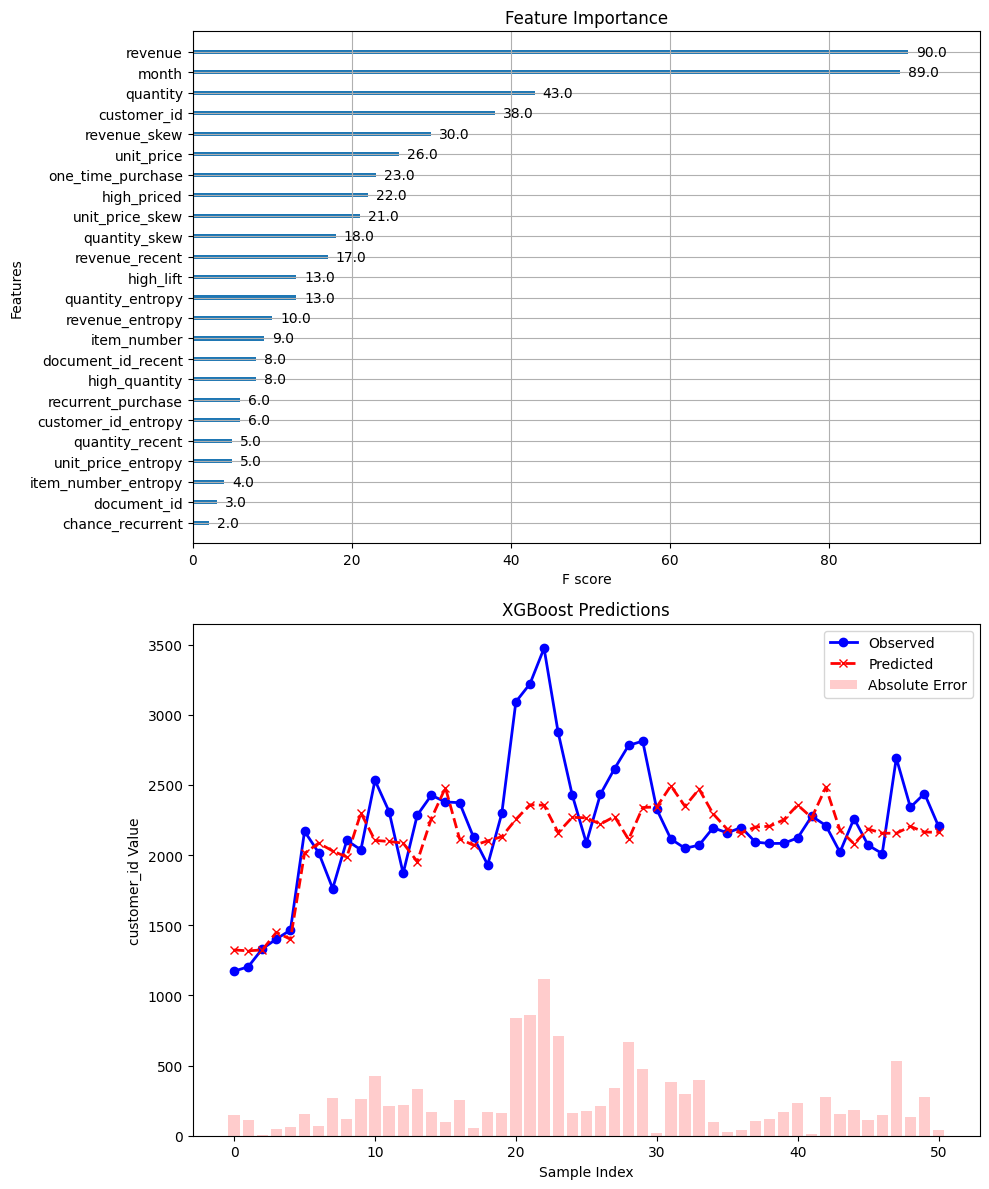

In [192]:
xgboost(pd.read_csv('transformed_371.csv'), target='customer_id', window=1, estimators=30, lr=0.1, g=0.5)

Average R2 Score: 0.7046891656782812
Average Mean Squared Error: 138410.58247356623
Average MAPE: 0.5083228220732231
Average Mean Percent Correct: 0.7807807807807807


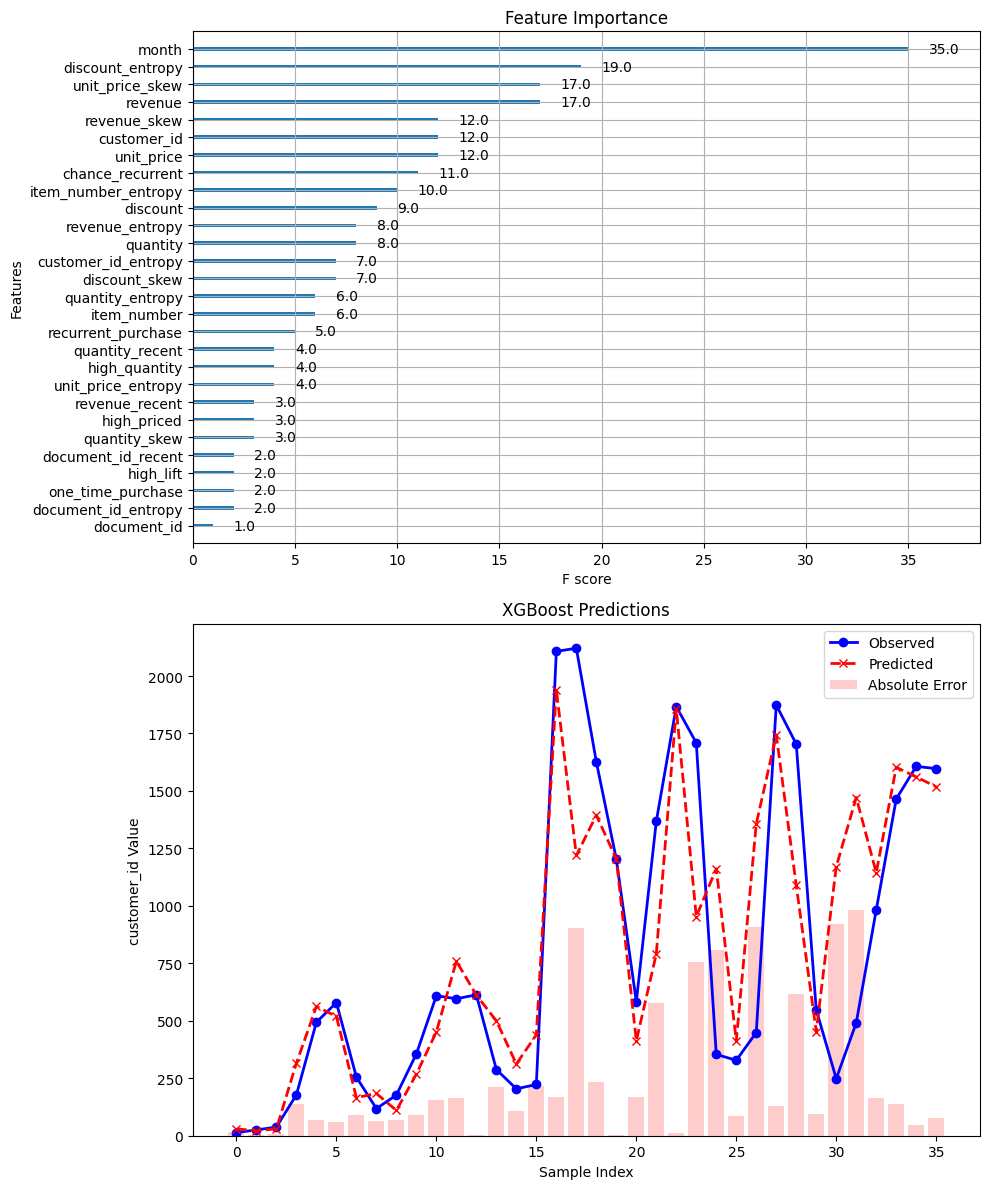

In [210]:
xgboost(pd.read_csv('transformed_eba.csv'), target='customer_id', window=1, estimators=30, lr=0.7, g=0.5)

Average R2 Score: 0.9012016543665483
Average Mean Squared Error: 25153.266412715984
Average MAPE: 0.07861502086990747
Average Mean Percent Correct: 0.9396551724137931


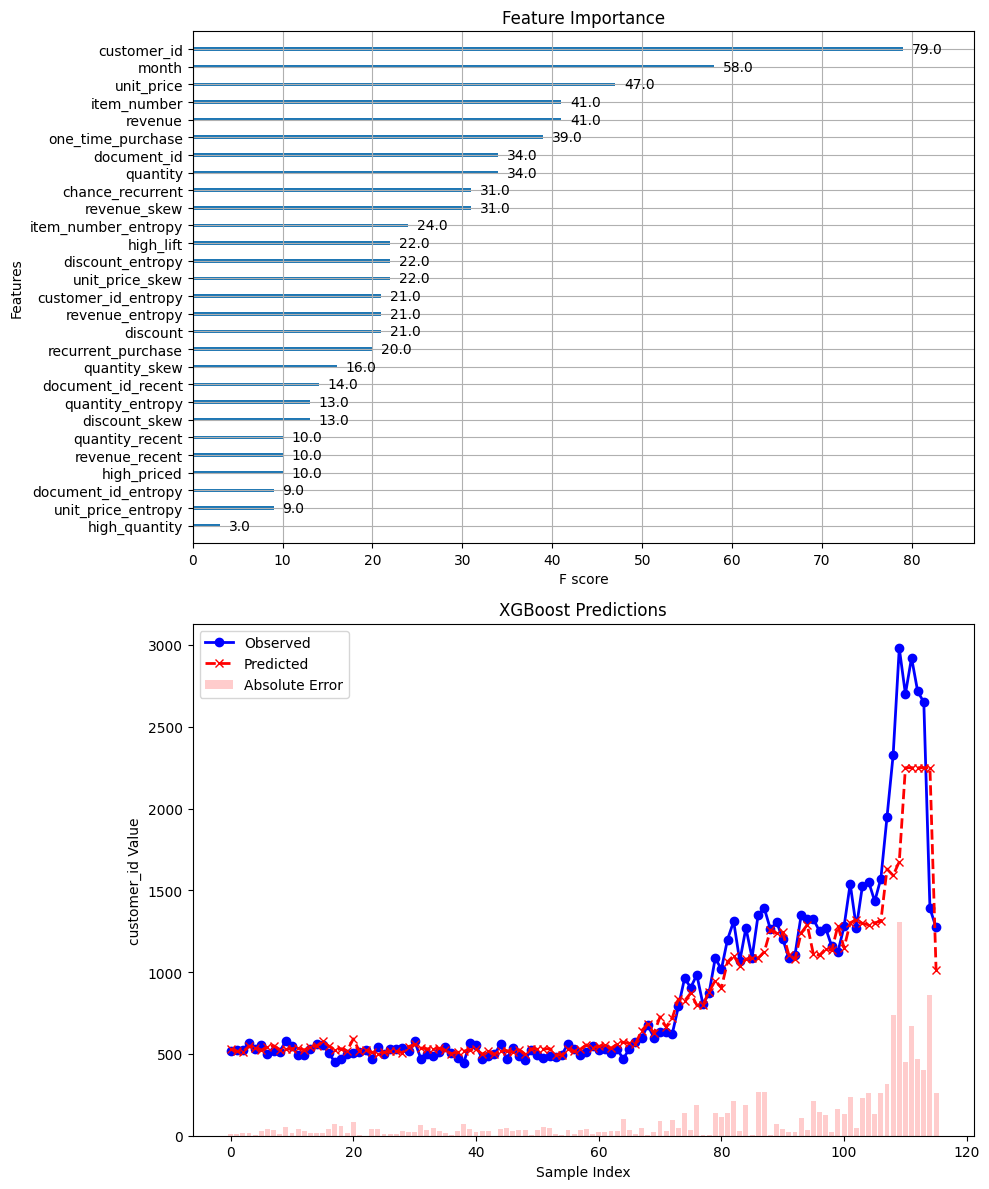

In [184]:
xgboost(pd.read_csv('transformed_fb5.csv'), target='customer_id', window=1, estimators=30, lr=0.1, g=0.5, cut=2)

Average R2 Score: 0.42803577256624575
Average Mean Squared Error: 37547.18367831234
Average MAPE: 0.21893567555329813
Average Mean Percent Correct: 0.47333333333333333


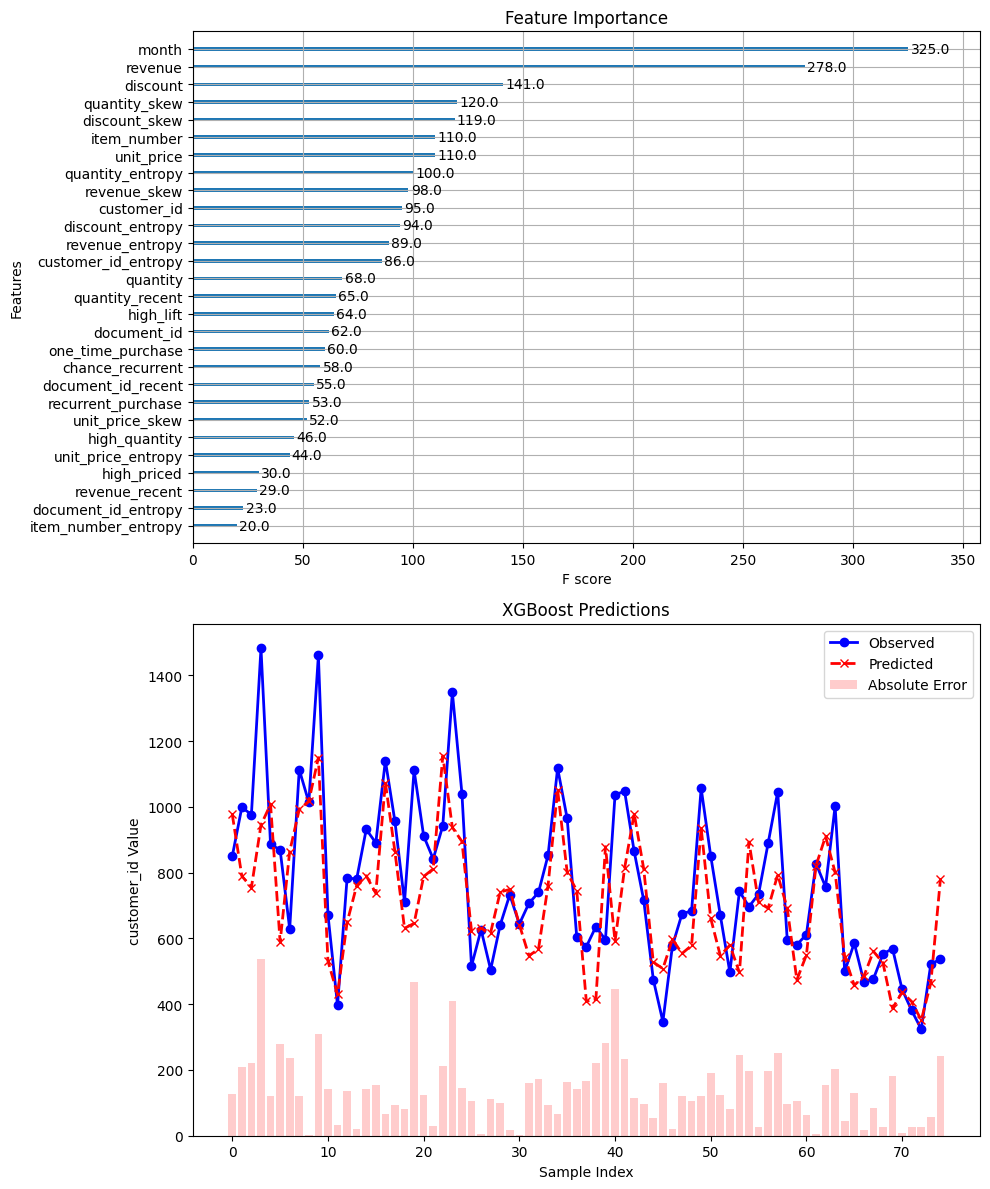

In [185]:
xgboost(pd.read_csv('transformed_f3d.csv'), target='customer_id', window=1, estimators=80, lr=0.1, g=0.1)

In [186]:
# Lasso Regression
def lasso_regression(data, target='revenue', window=1, cut=1, drop_timeline=True, alpha=1.0):
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score, mean_squared_error
    from sklearn.linear_model import Lasso
    import numpy as np

    # Define MAPE function
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true))
    
    # Define Mean Percent Correct
    def mean_percent_correct(y_true, y_pred):
        threshold = np.std(y_true) / 2
        correct = np.abs(y_true - y_pred) < threshold
        return np.mean(correct)

    # Split data
    X, y = encoder(data, target, window=window, cut=cut, drop_timeline=drop_timeline)

    # Scale data

    # Initialize KFold
    kf = KFold(n_splits=2, shuffle=True, random_state=42)

    # Lists to store performance metrics
    mse_scores = []
    r2_scores = []
    mape_scores = []
    predictions = []
    mpc_scores = []

    # K-Fold Cross-Validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Model
        model = Lasso(alpha=alpha, max_iter=50000, tol=0.1)
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Calculate performance metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mpc = mean_percent_correct(y_test, y_pred)
        
        # Append metrics to lists
        mse_scores.append(mse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        predictions.append(y_pred)
        mpc_scores.append(mpc)

    # Calculate average performance metrics
    avg_r2 = np.mean(r2_scores)
    avg_mse = np.mean(mse_scores)
    avg_mape = np.mean(mape_scores)
    avg_mpc = np.mean(mpc_scores)

    print(f"Average R2 Score: {avg_r2}")
    print(f"Average Mean Squared Error: {avg_mse}")
    print(f"Average MAPE: {avg_mape}")
    print(f"Average Mean Percent Correct: {avg_mpc}")
    
    # Plot predictions
    import matplotlib.pyplot as plt
    
    # Calculate absolute error
    errors = np.abs(y_test.values - y_pred)
    
    # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))

    # Plot predictions on the first subplot
    ax[0].plot(y_test.values, label='Observed', color='blue', linewidth=2, marker='o')
    ax[0].plot(y_pred, label='Predicted', color='red', linewidth=2, marker='x', linestyle='dashed')
    ax[0].bar(range(len(errors)), errors, alpha=0.2, color='red', label='Absolute Error')
    ax[0].set_title('Lasso Regression Predictions')
    ax[0].set_ylabel(f'{target} Value')
    ax[0].set_xlabel('Sample Index')
    ax[0].legend()

    # Sort coefficients
    coef = model.coef_
    indices = np.argsort(np.abs(coef))[::-1]
    coef = coef[indices]
    features = X.columns[indices]
    

    # Plot coefficients on the second subplot
    ax[1].bar(features, coef)
    ax[1].set_title('Lasso Regression Coefficients')
    ax[1].set_ylabel('Coefficient Value')
    ax[1].set_xlabel('Feature')
    ax[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

Average R2 Score: 0.6964408471048946
Average Mean Squared Error: 57346574231.59828
Average MAPE: 0.13448546074391
Average Mean Percent Correct: 0.825603318250377


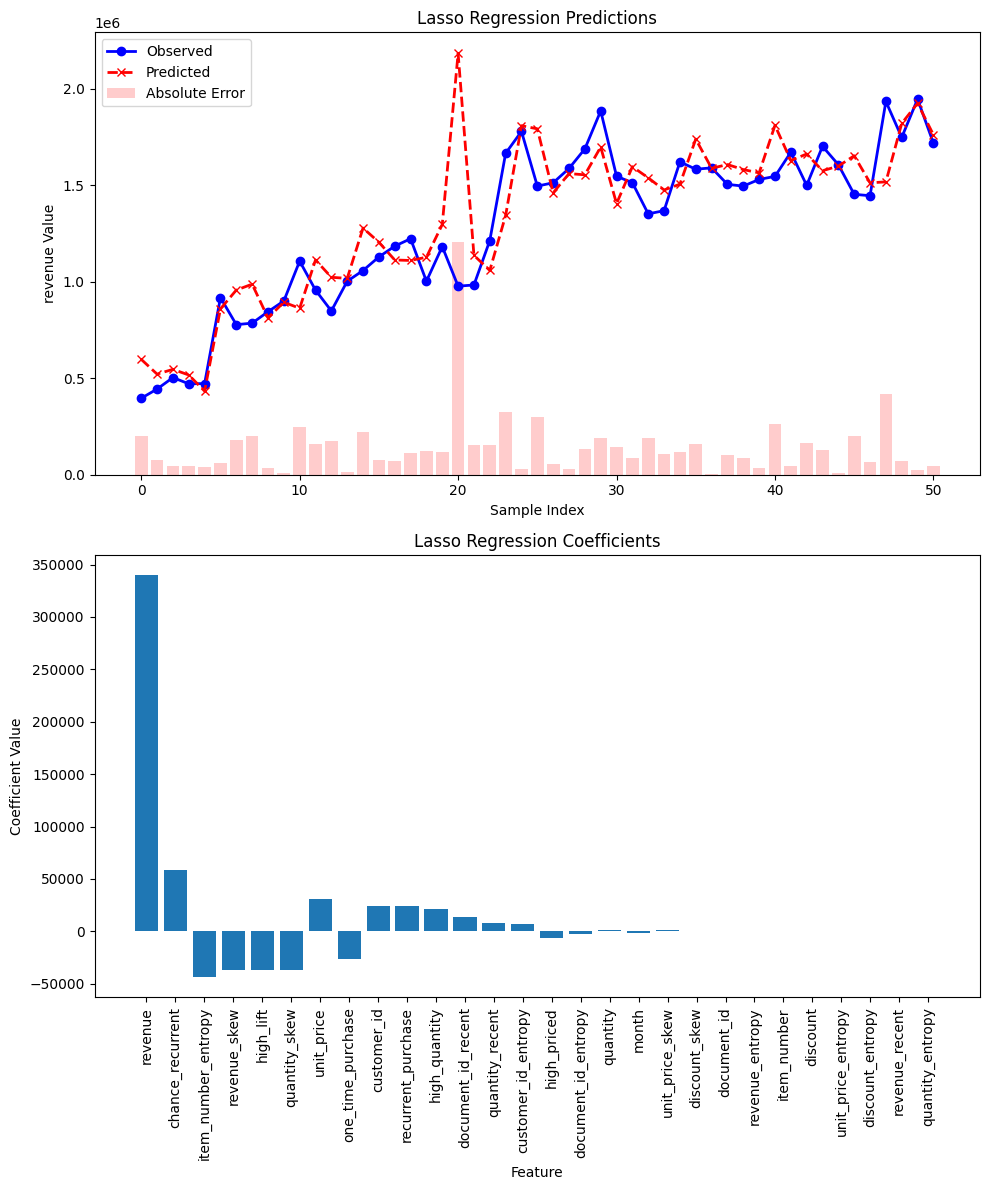

In [207]:
lasso_regression(pd.read_csv('transformed_371.csv'), target='revenue', window=1, cut=1, drop_timeline=True, alpha=5000)

Average R2 Score: 0.805542776535423
Average Mean Squared Error: 93524.13097395262
Average MAPE: 0.6463292885996745
Average Mean Percent Correct: 0.862987987987988


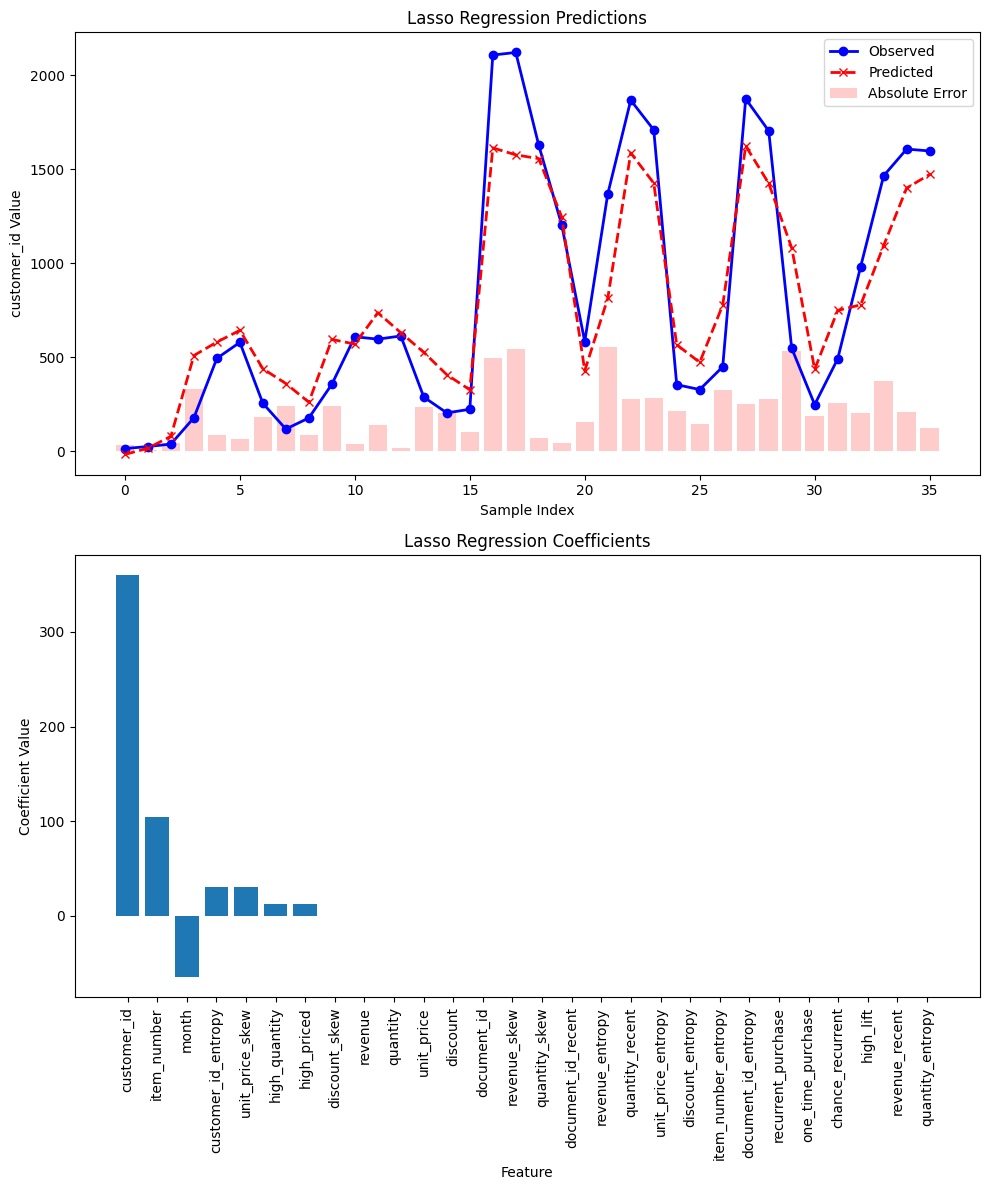

In [199]:
lasso_regression(pd.read_csv('transformed_eba.csv'), target='customer_id', window=1, cut=1, drop_timeline=True, alpha=100)

Average R2 Score: 0.8746080636798383
Average Mean Squared Error: 23565.86485108332
Average MAPE: 0.11245042118852663
Average Mean Percent Correct: 0.9353448275862069


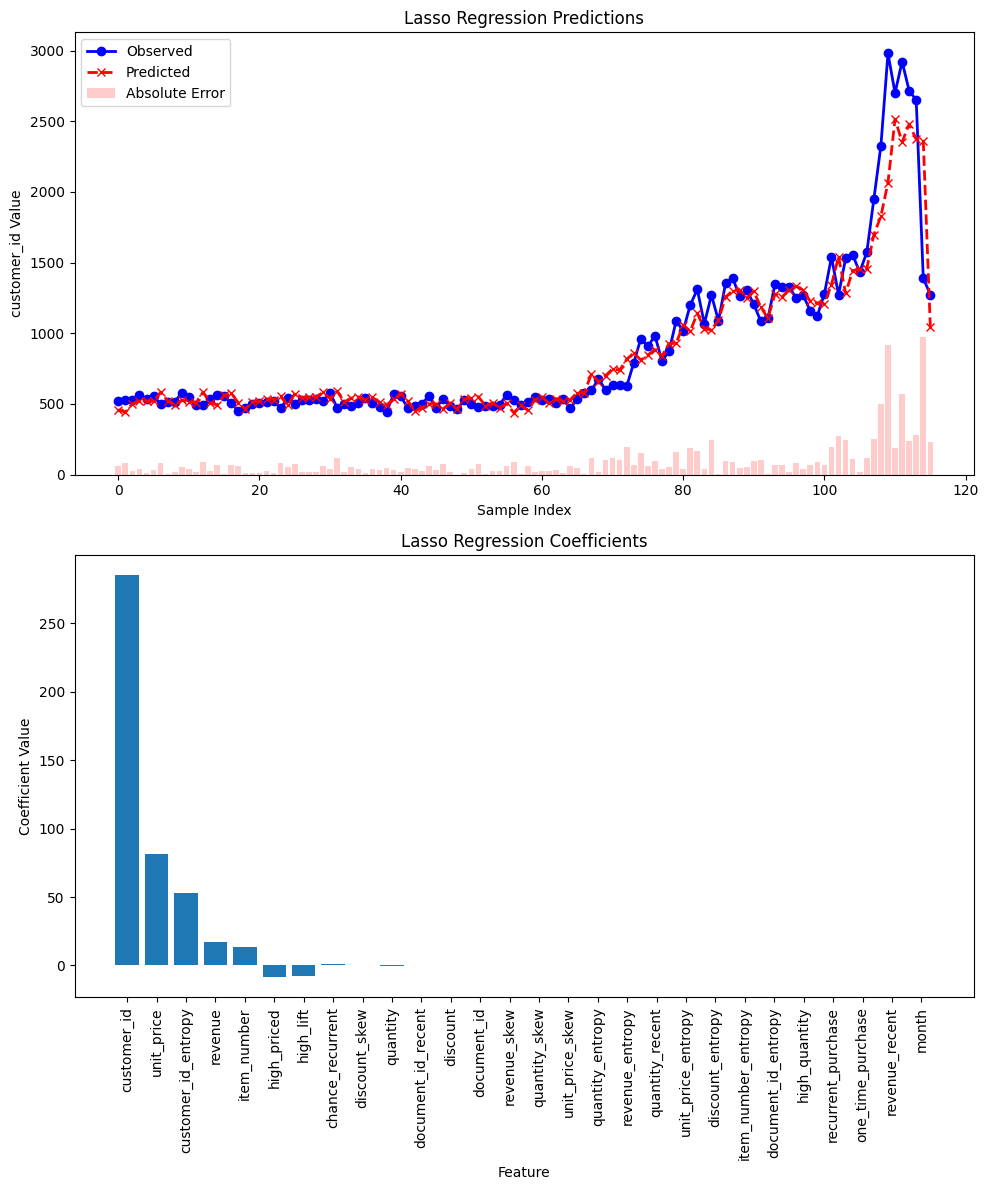

In [189]:
lasso_regression(pd.read_csv('transformed_fb5.csv'), target='customer_id', window=1, cut=2, drop_timeline=True, alpha=10)

Average R2 Score: 0.3985691871537199
Average Mean Squared Error: 39318.85093682233
Average MAPE: 0.2320856692271623
Average Mean Percent Correct: 0.52


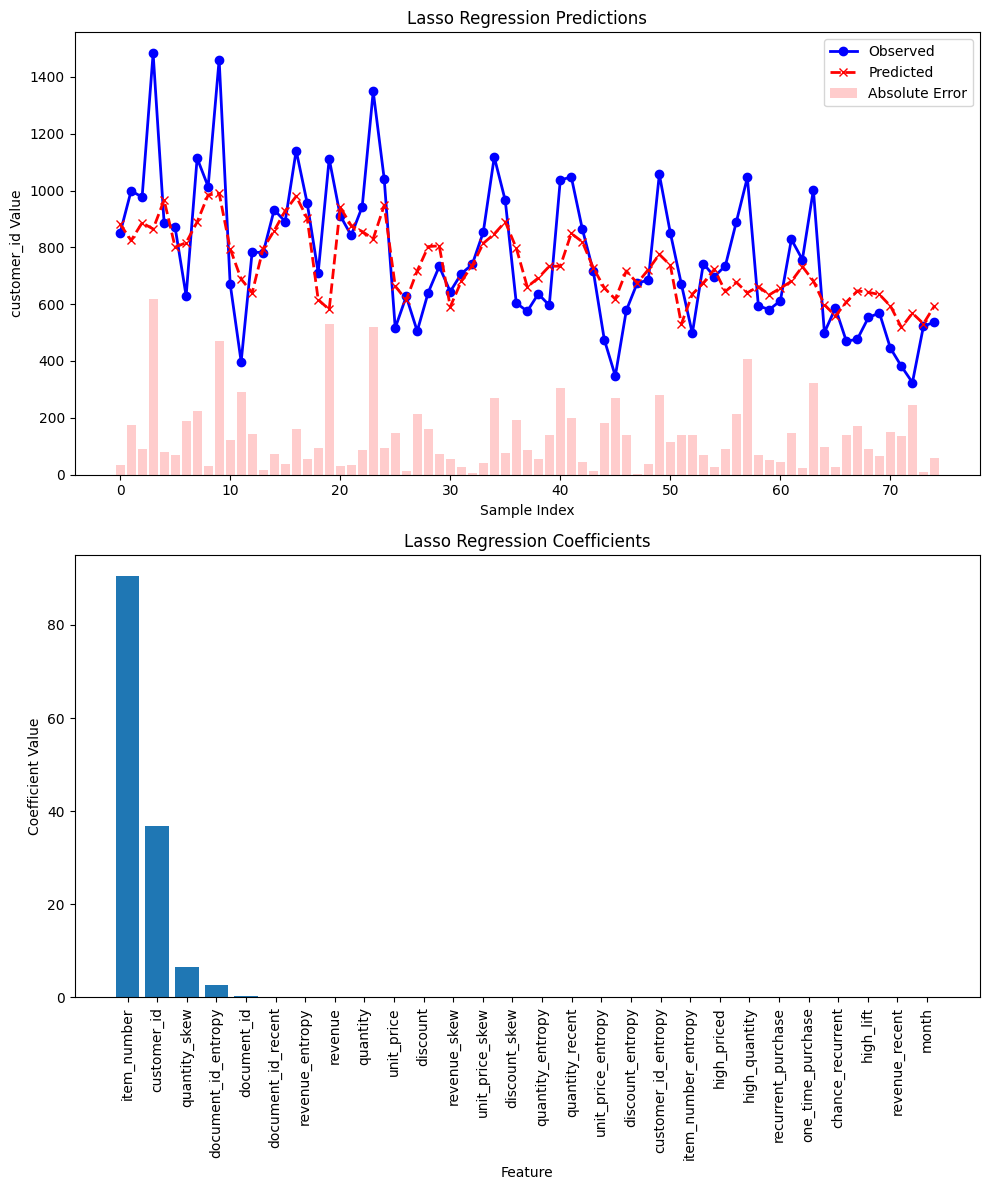

In [202]:
lasso_regression(pd.read_csv('transformed_f3d.csv'), target='customer_id', window=1, cut=1, drop_timeline=True, alpha=50)